In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cp_linear_regression import CP_LinearRegression
from traditional_ml import traditionalML
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
import time

In [2]:
file = open("mnist_train.csv")
data_train = pd.read_csv(file)

y_train = np.array(data_train.iloc[:, 0])
x_train = np.array(data_train.iloc[:, 1:])


In [3]:
def generate_data(sample_size, noise_variance, beta):
    """ Generates data according to a model that has true CP rank of 2.
    
        Arguments:
            sample_size: Sample size
            noise_variance: Noise to add to the data
        Returns:
            beta: True predictor
            X_train: Training data
            Y_hard: Labels {-1, 1} according to X (for classification)
            Y_soft: Soft labels according to X (for linear regression)
    """
    
    h, w = beta.shape
    X_train = np.random.randn(sample_size, h, w) 
    X_train_vec = np.reshape(X_train, (sample_size, h*w))
    
    vec_cross_beta = np.reshape(beta, (h*w, 1))
    Y_soft = np.zeros((sample_size, 1))
    
    for i in range(sample_size):
        epsilon = noise_variance * np.random.randn(1, 1)
        x_i = X_train_vec[i, :]
        y_i = (x_i @ vec_cross_beta) + epsilon
        Y_soft[i, :] = y_i
        
    Y_hard = np.sign(Y_soft)
    
    return beta, X_train, Y_hard, Y_soft 

In [6]:
sample_size = 1500
variance = 1.5
CP_rank = 2
dct_cp = defaultdict(list)
dct_vec = defaultdict(list)
beta_arr = []
for i in tqdm(range(10)):
    beta = x_train[y_train == i][2].reshape(28, 28) / 255
    beta_arr.append(beta)
    true_pred, X, Y_hard, Y_soft = generate_data(sample_size, variance, beta)

    # training CP SVM model
    CP_LinReg = CP_LinearRegression(CP_rank=CP_rank) # instantiating class
    start = time.time()
    svm_dict = CP_LinReg.fit(X, Y_soft, print_iterations=False, max_iterations=6, sensitivity=0) # fitting data (X, y)
    end = time.time()
    cp_svm_reconstructed = CP_LinReg.reconstructTensor(solved_dict=svm_dict, tensor_n_dim=2) # reconstruct tensor
    dct_cp['time'].append(end - start)

    # training traditional SVM model
    vec_SVM = traditionalML(algorithm='Linear Regression') # instantiating class
    vec_X = np.reshape(X, (sample_size, -1)) # vectorizing data
    start = time.time()
    vec_svm_params = vec_SVM.fit(vec_X, Y_soft, max_iterations=6, sensitivity=0)
    end = time.time()
    vec_svm_reconstructed = np.reshape(vec_svm_params, (cp_svm_reconstructed.shape))
    dct_vec['time'].append(end - start)

    # comparing CP SVM to traditional SVM model
    cp_mse_val, cp_cos_dis, cp_recon_err = CP_LinReg.evaluateMetrics(cp_svm_reconstructed, true_pred) # evaluate metrics
    vec_mse_val, vec_cos_dis, vec_recon_err = CP_LinReg.evaluateMetrics(vec_svm_reconstructed, true_pred)
    dct_cp['mse'].append(cp_mse_val)
    dct_cp['cos'].append(cp_cos_dis[0][0])
    dct_cp['recon_err'].append(cp_recon_err)
    dct_cp['predictor'].append(cp_svm_reconstructed)

    dct_vec['mse'].append(vec_mse_val)
    dct_vec['cos'].append(vec_cos_dis[0][0])
    dct_vec['recon_err'].append(vec_recon_err)
    dct_vec['predictor'].append(vec_svm_reconstructed)

  0%|          | 0/10 [00:00<?, ?it/s]

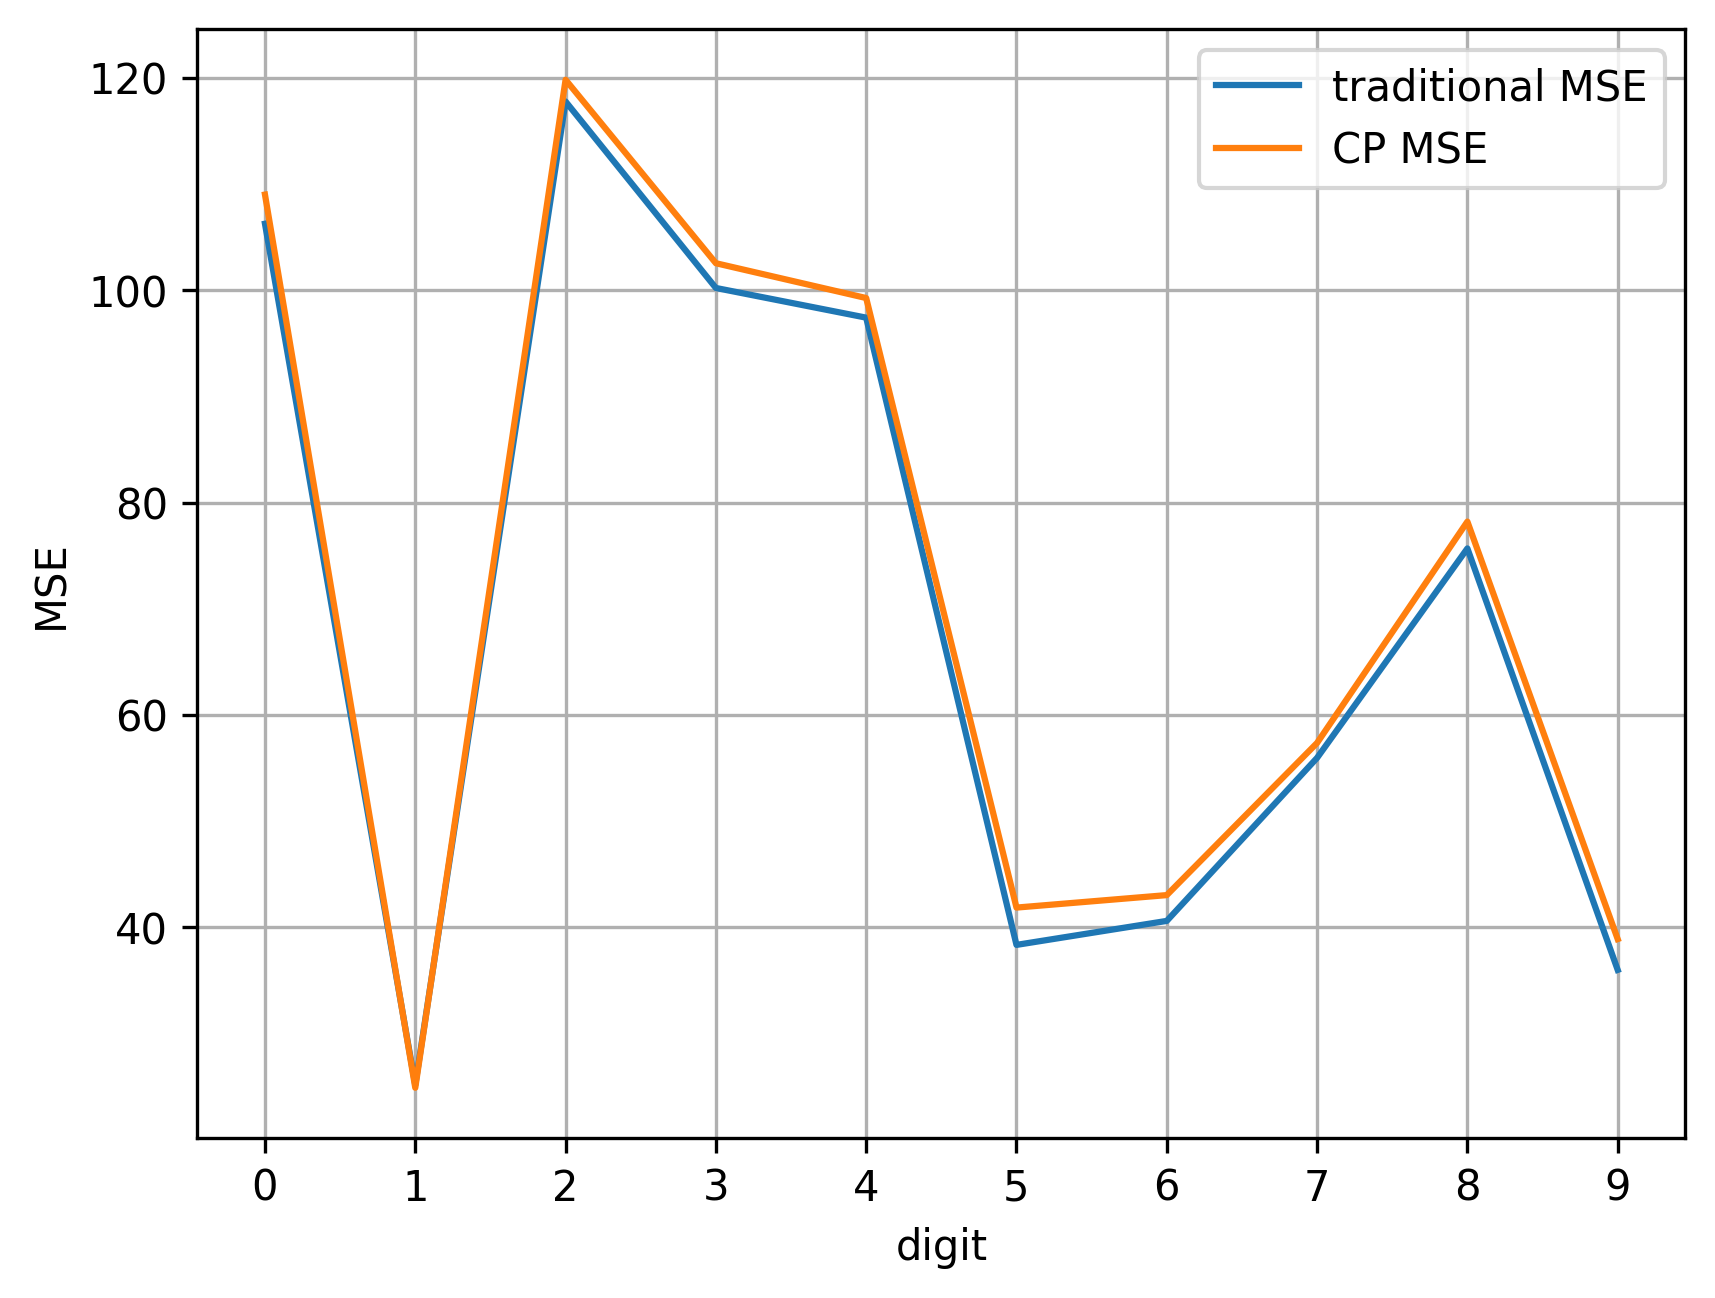

In [22]:
plt.figure(dpi=300)
plt.plot(np.arange(10), dct_vec['mse'], label='traditional MSE')
plt.plot(np.arange(10), dct_cp['mse'], label='CP MSE')
plt.xticks(np.arange(10))
plt.ylabel('MSE')
plt.xlabel('digit')
plt.legend()
plt.grid()
plt.savefig('images/mse.png')
plt.show()


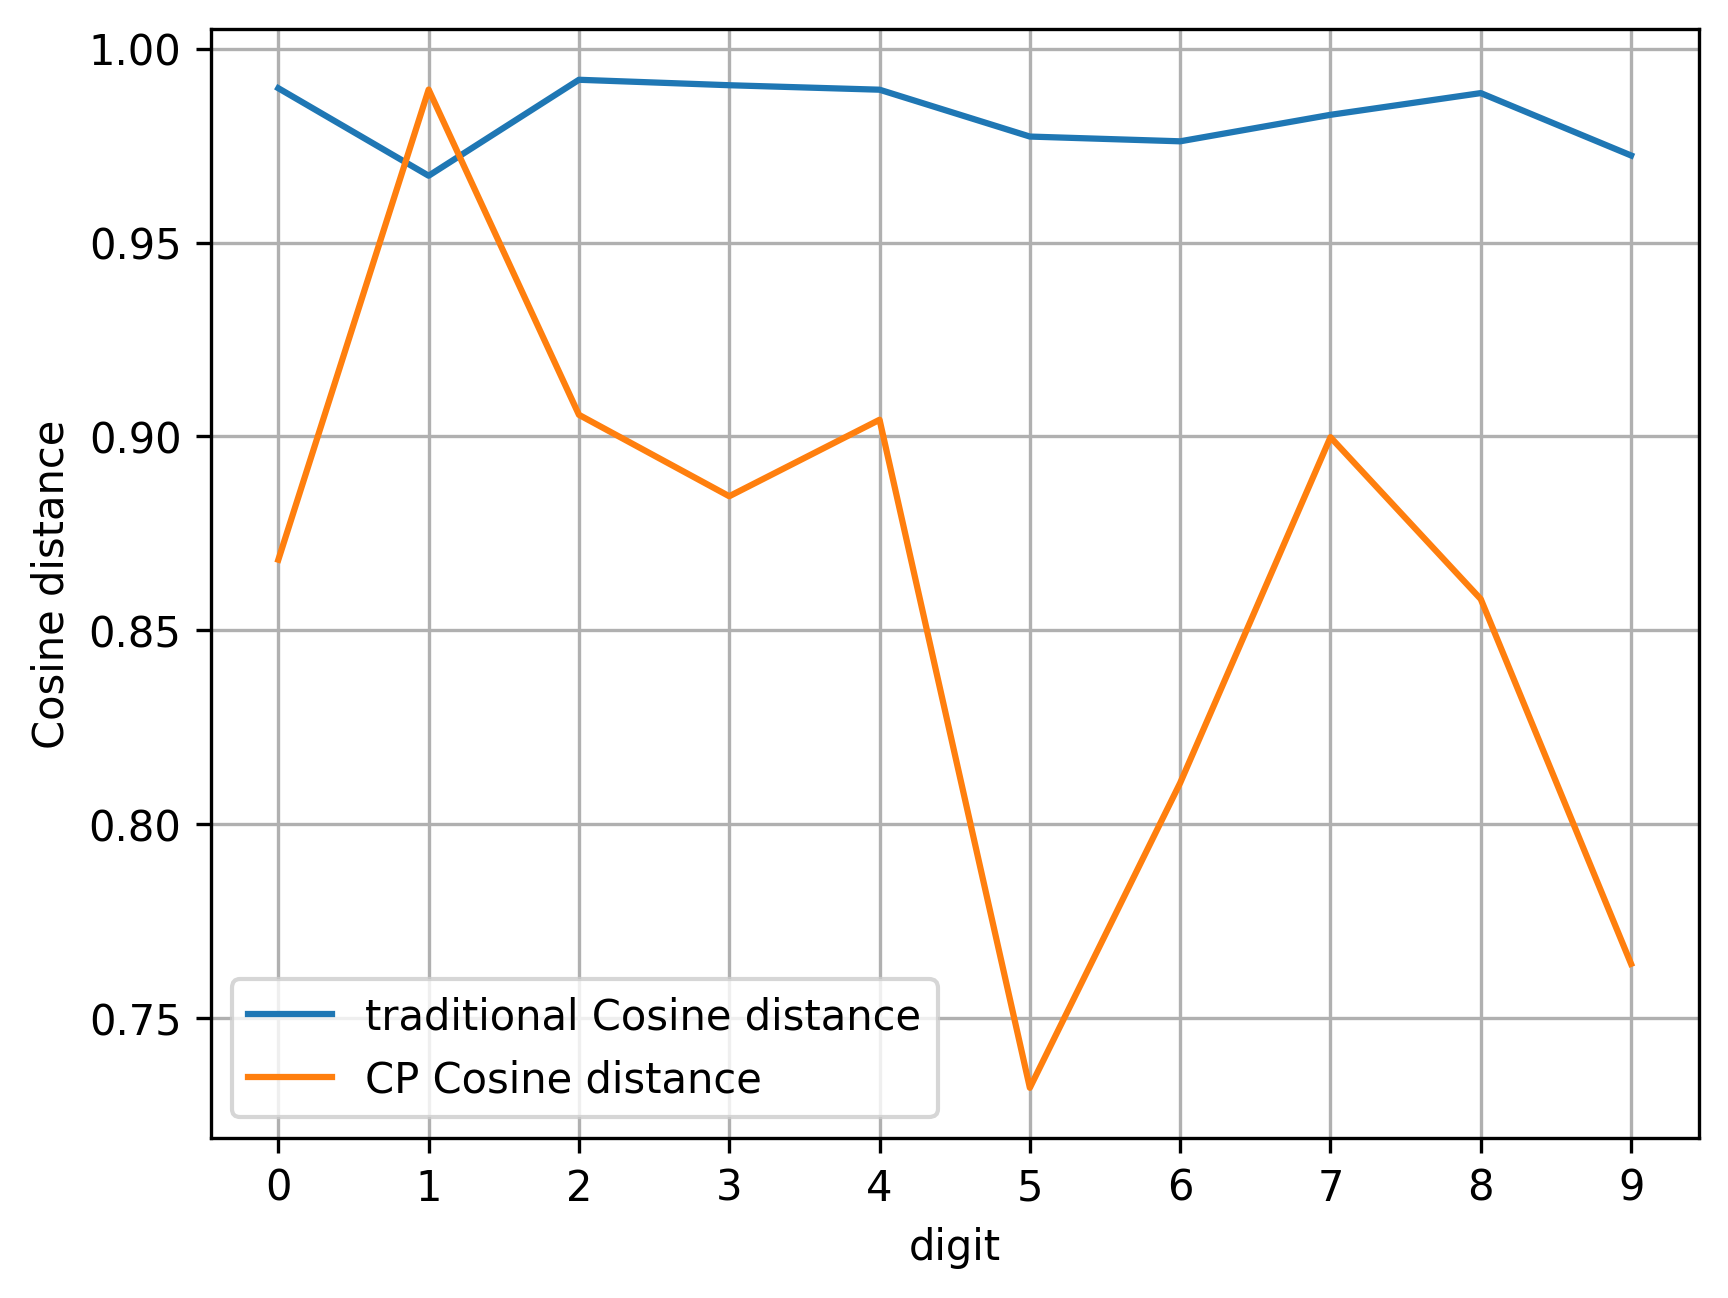

In [23]:
plt.figure(dpi=300)
plt.plot(np.arange(10), dct_vec['cos'], label='traditional Cosine distance')
plt.plot(np.arange(10), dct_cp['cos'], label='CP Cosine distance')
plt.xticks(np.arange(10))
plt.legend()
plt.ylabel('Cosine distance')
plt.xlabel('digit')
plt.grid()
plt.savefig('images/cd.png')
plt.show()

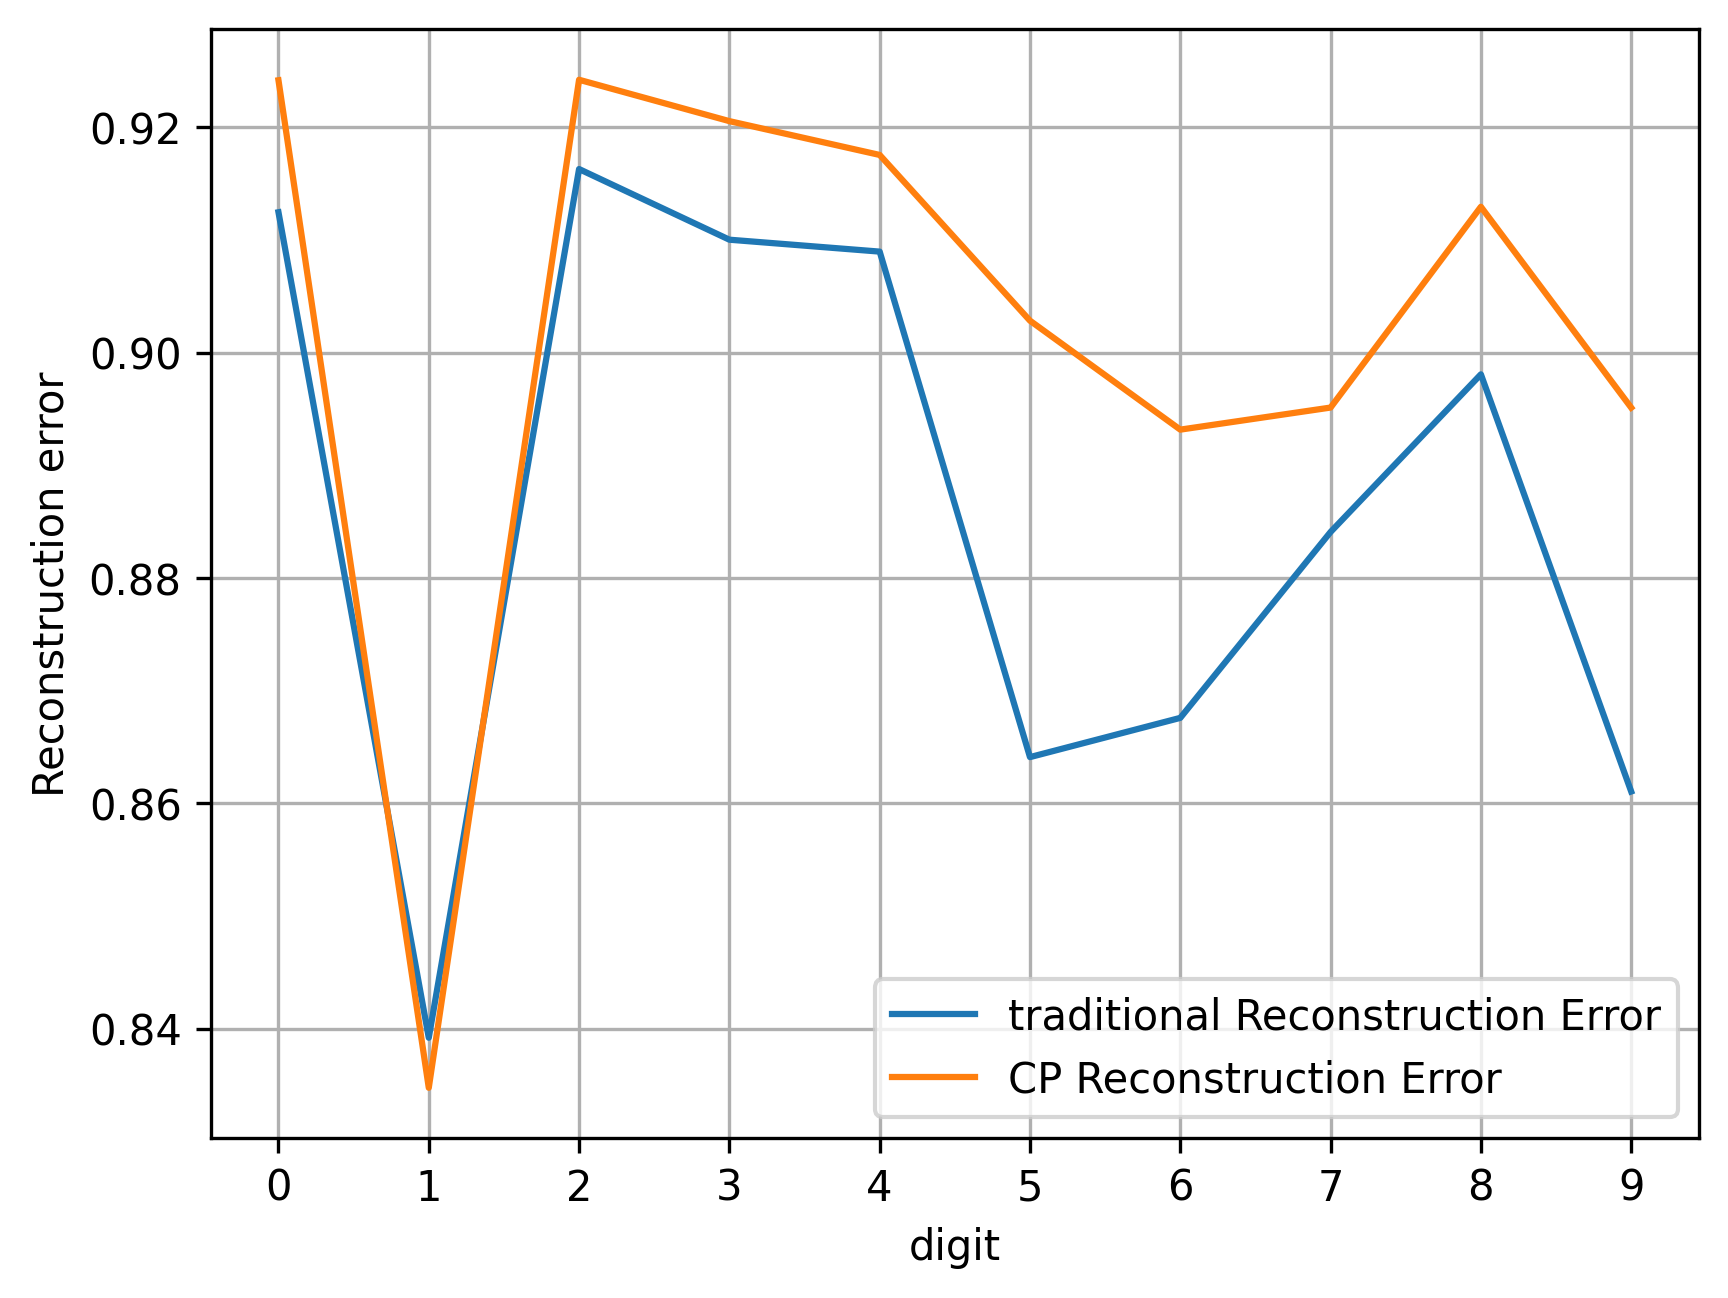

In [24]:
plt.figure(dpi=300)
plt.plot(np.arange(10), dct_vec['recon_err'], label='traditional Reconstruction Error')
plt.plot(np.arange(10), dct_cp['recon_err'], label='CP Reconstruction Error')
plt.xticks(np.arange(10))
plt.legend()
plt.grid()
plt.ylabel('Reconstruction error')
plt.xlabel('digit')
plt.savefig('images/re.png')
plt.show()

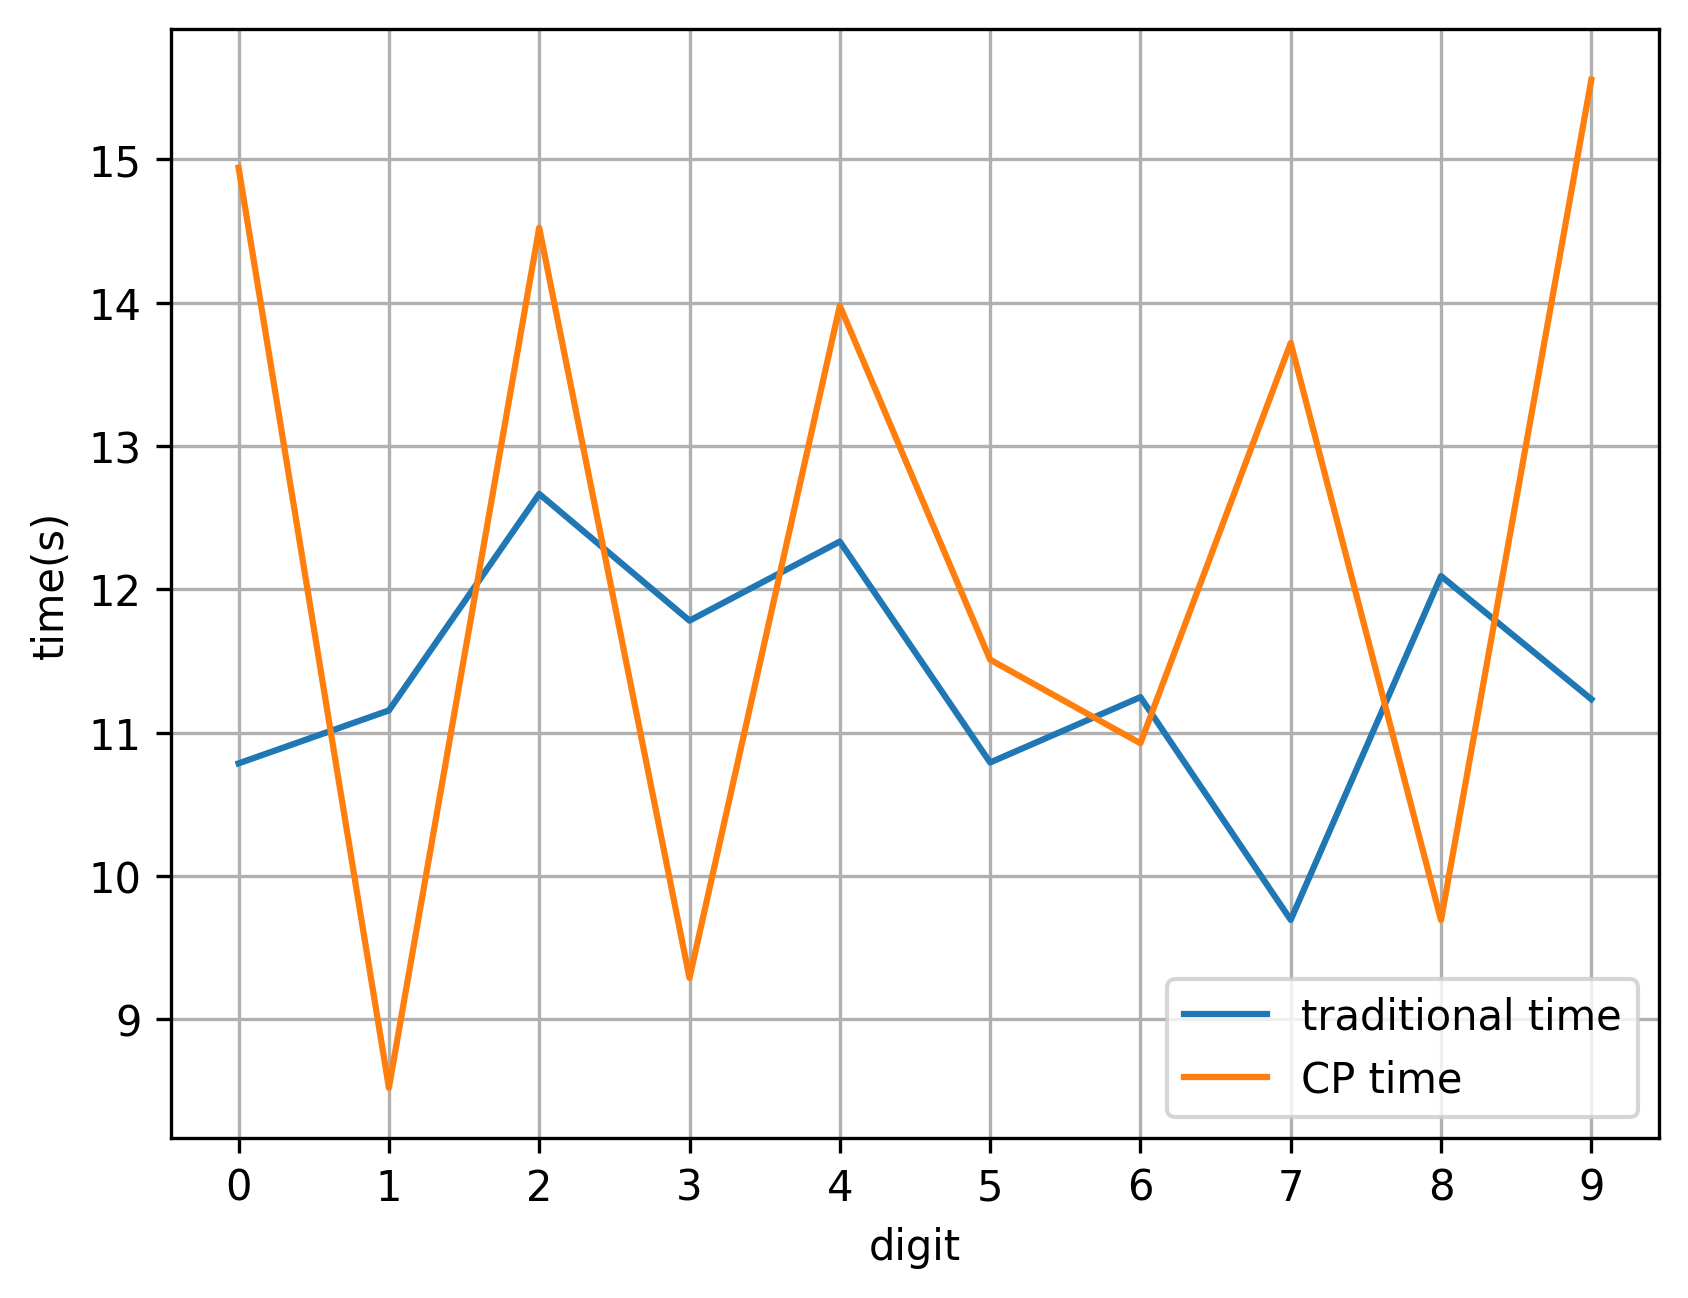

In [25]:
plt.figure(dpi=300)
plt.plot(np.arange(10), dct_vec['time'], label='traditional time')
plt.plot(np.arange(10), dct_cp['time'], label='CP time')
plt.xticks(np.arange(10))
plt.legend()
plt.grid()
plt.ylabel('time(s)')
plt.xlabel('digit')
plt.savefig('images/time.png')
plt.show()

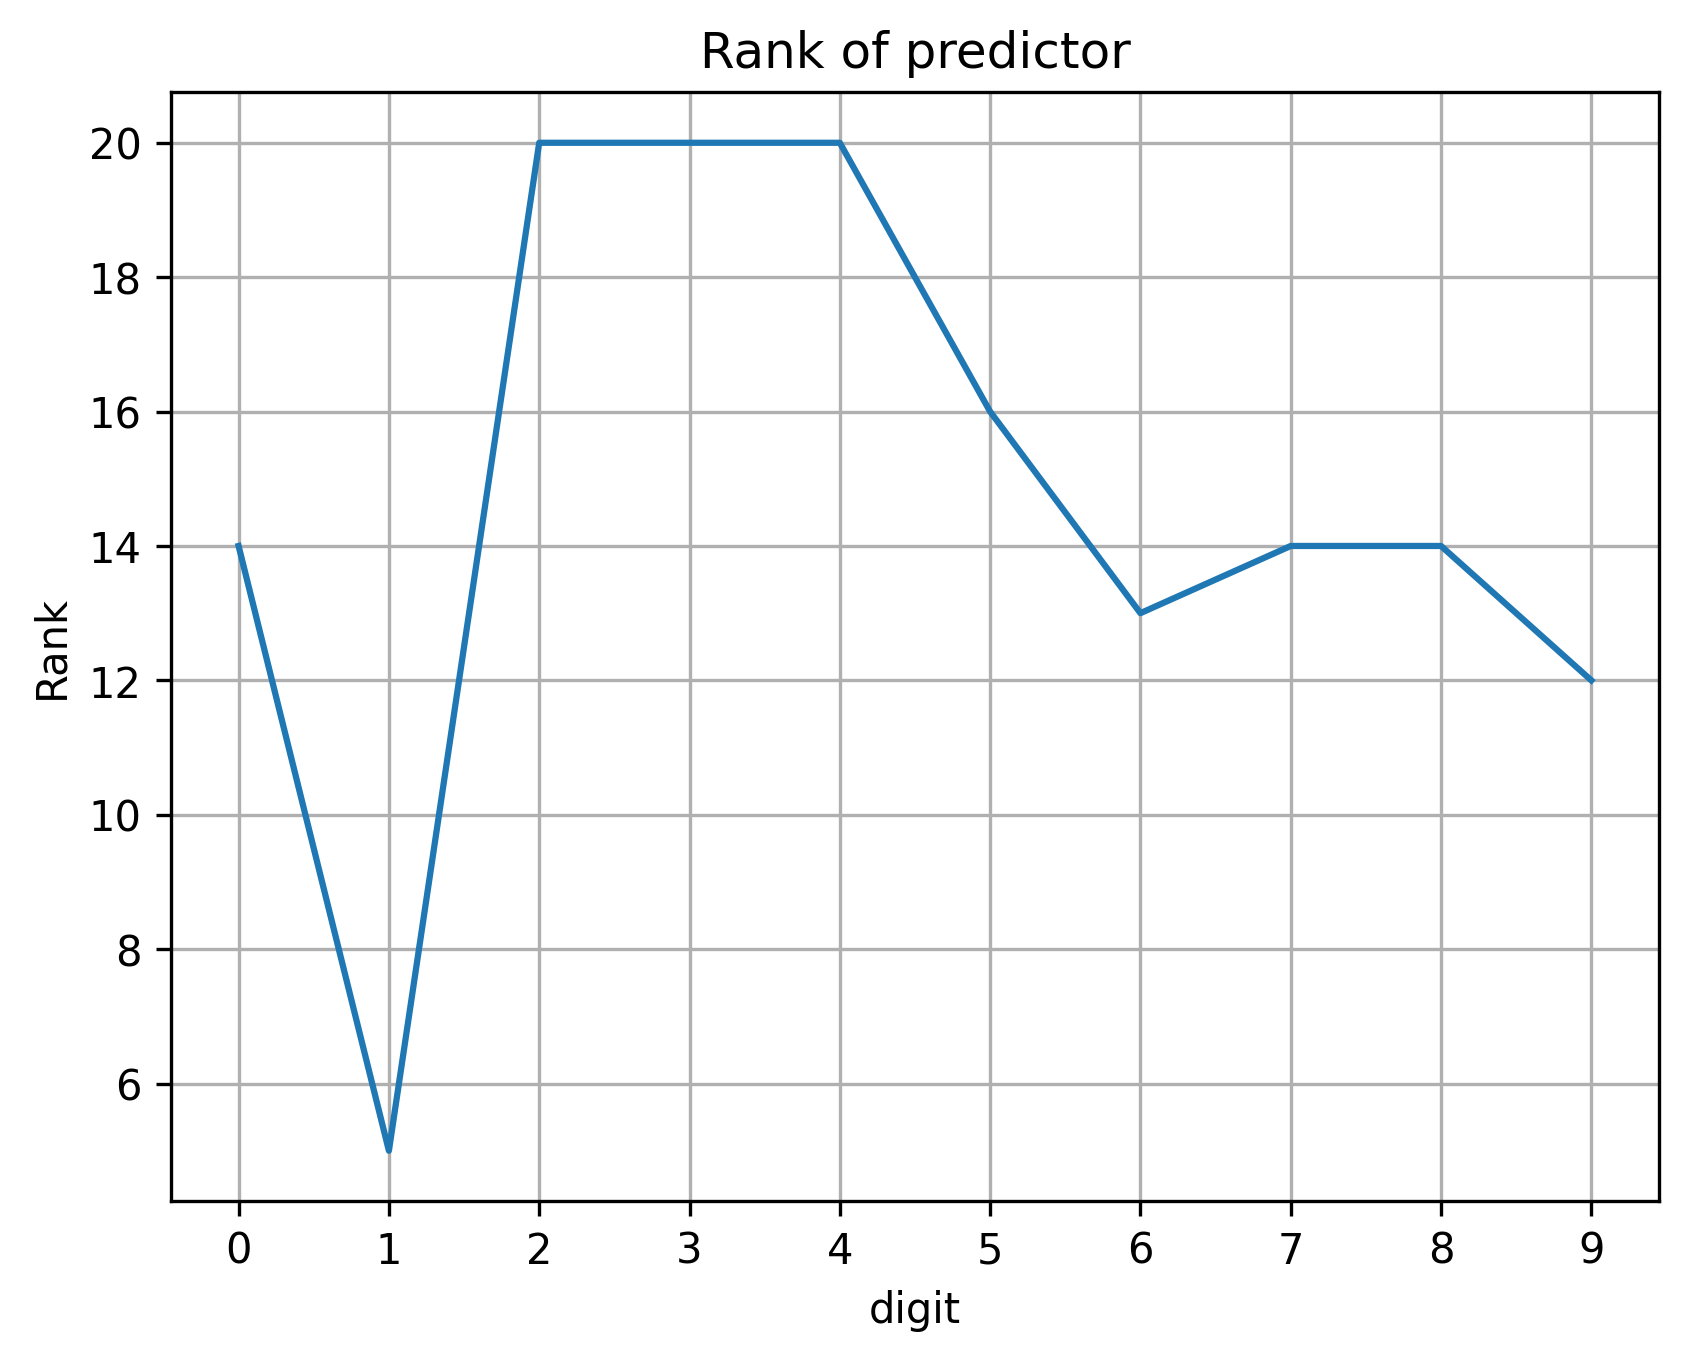

In [26]:
plt.figure(dpi=300)
plt.plot(np.arange(10), [np.linalg.matrix_rank(x) for x in beta_arr])
plt.xticks(np.arange(10))
plt.grid()
plt.title('Rank of predictor')
plt.ylabel('Rank')
plt.xlabel('digit')
plt.savefig('images/rank.png')
plt.show()

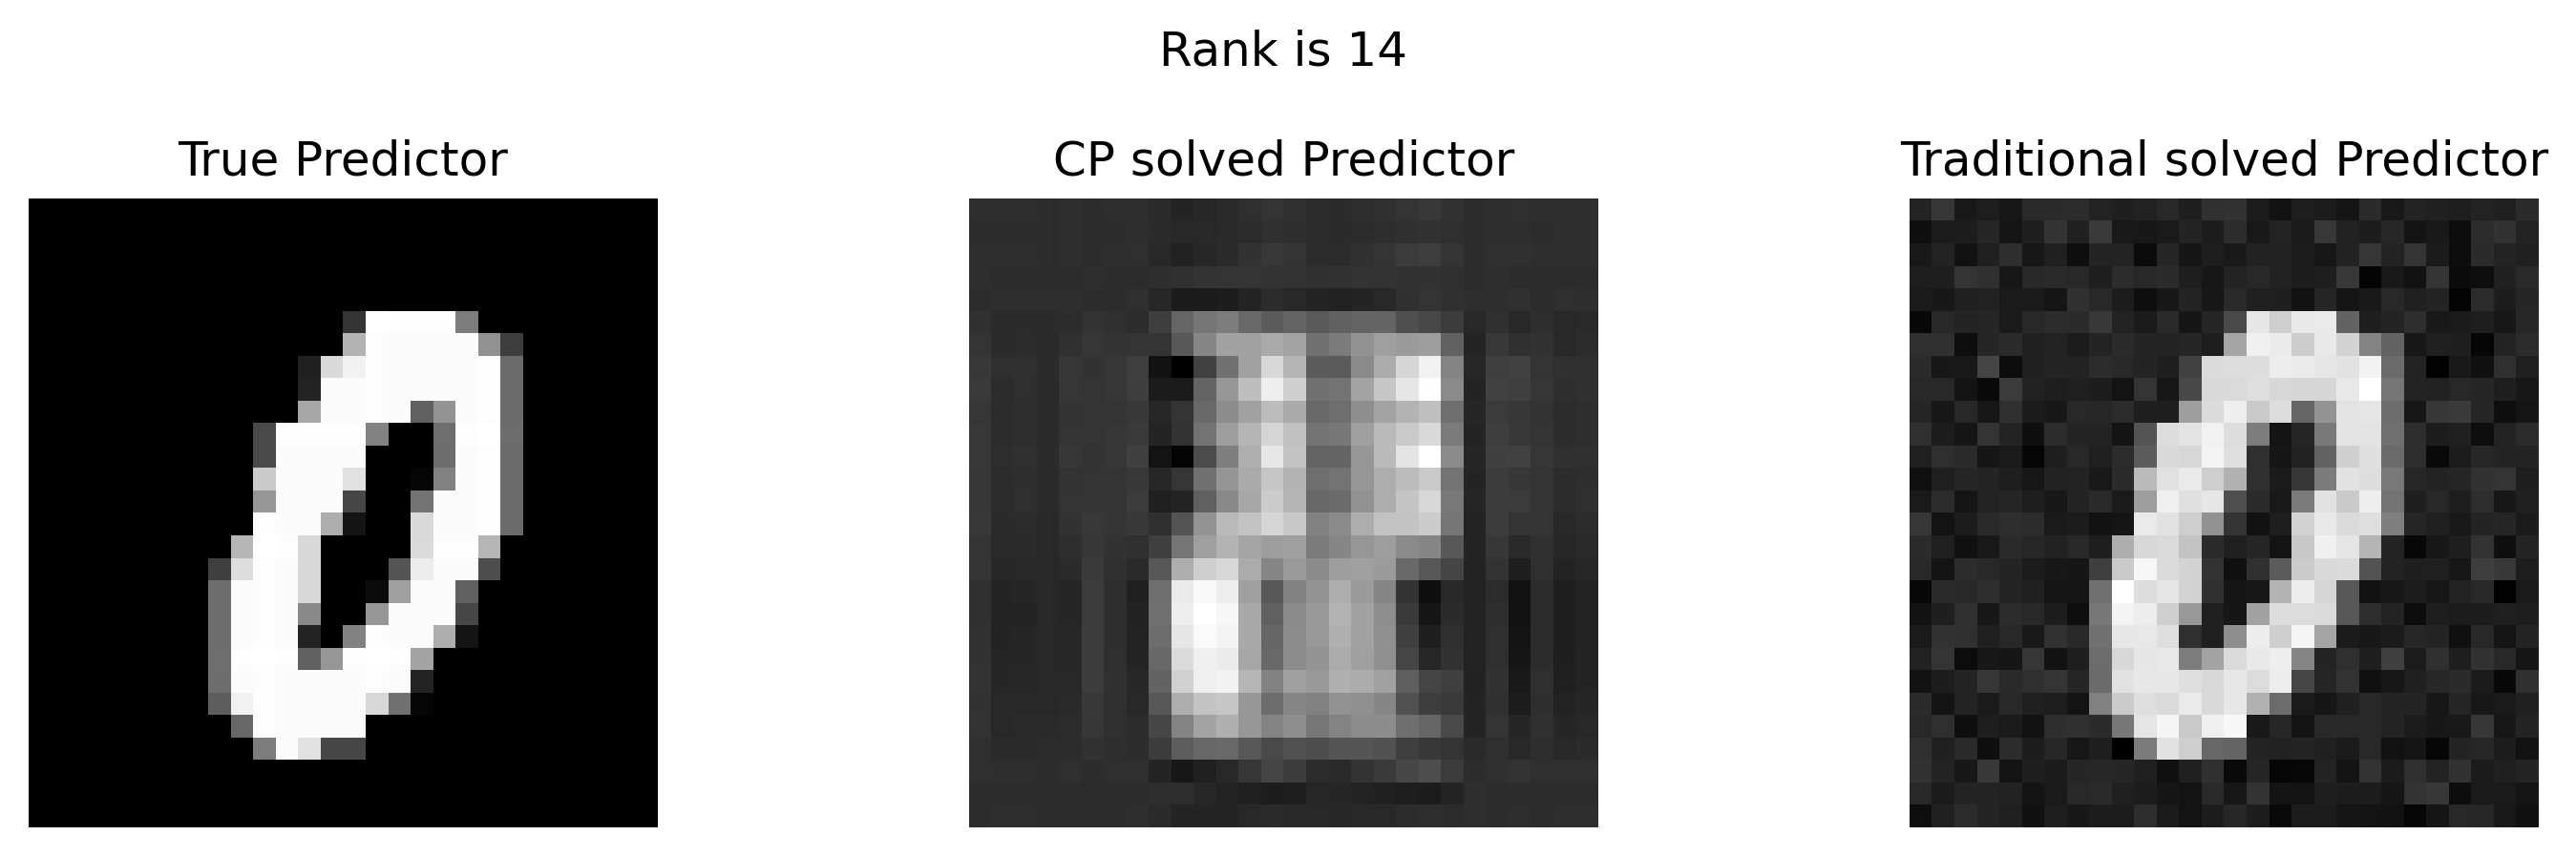

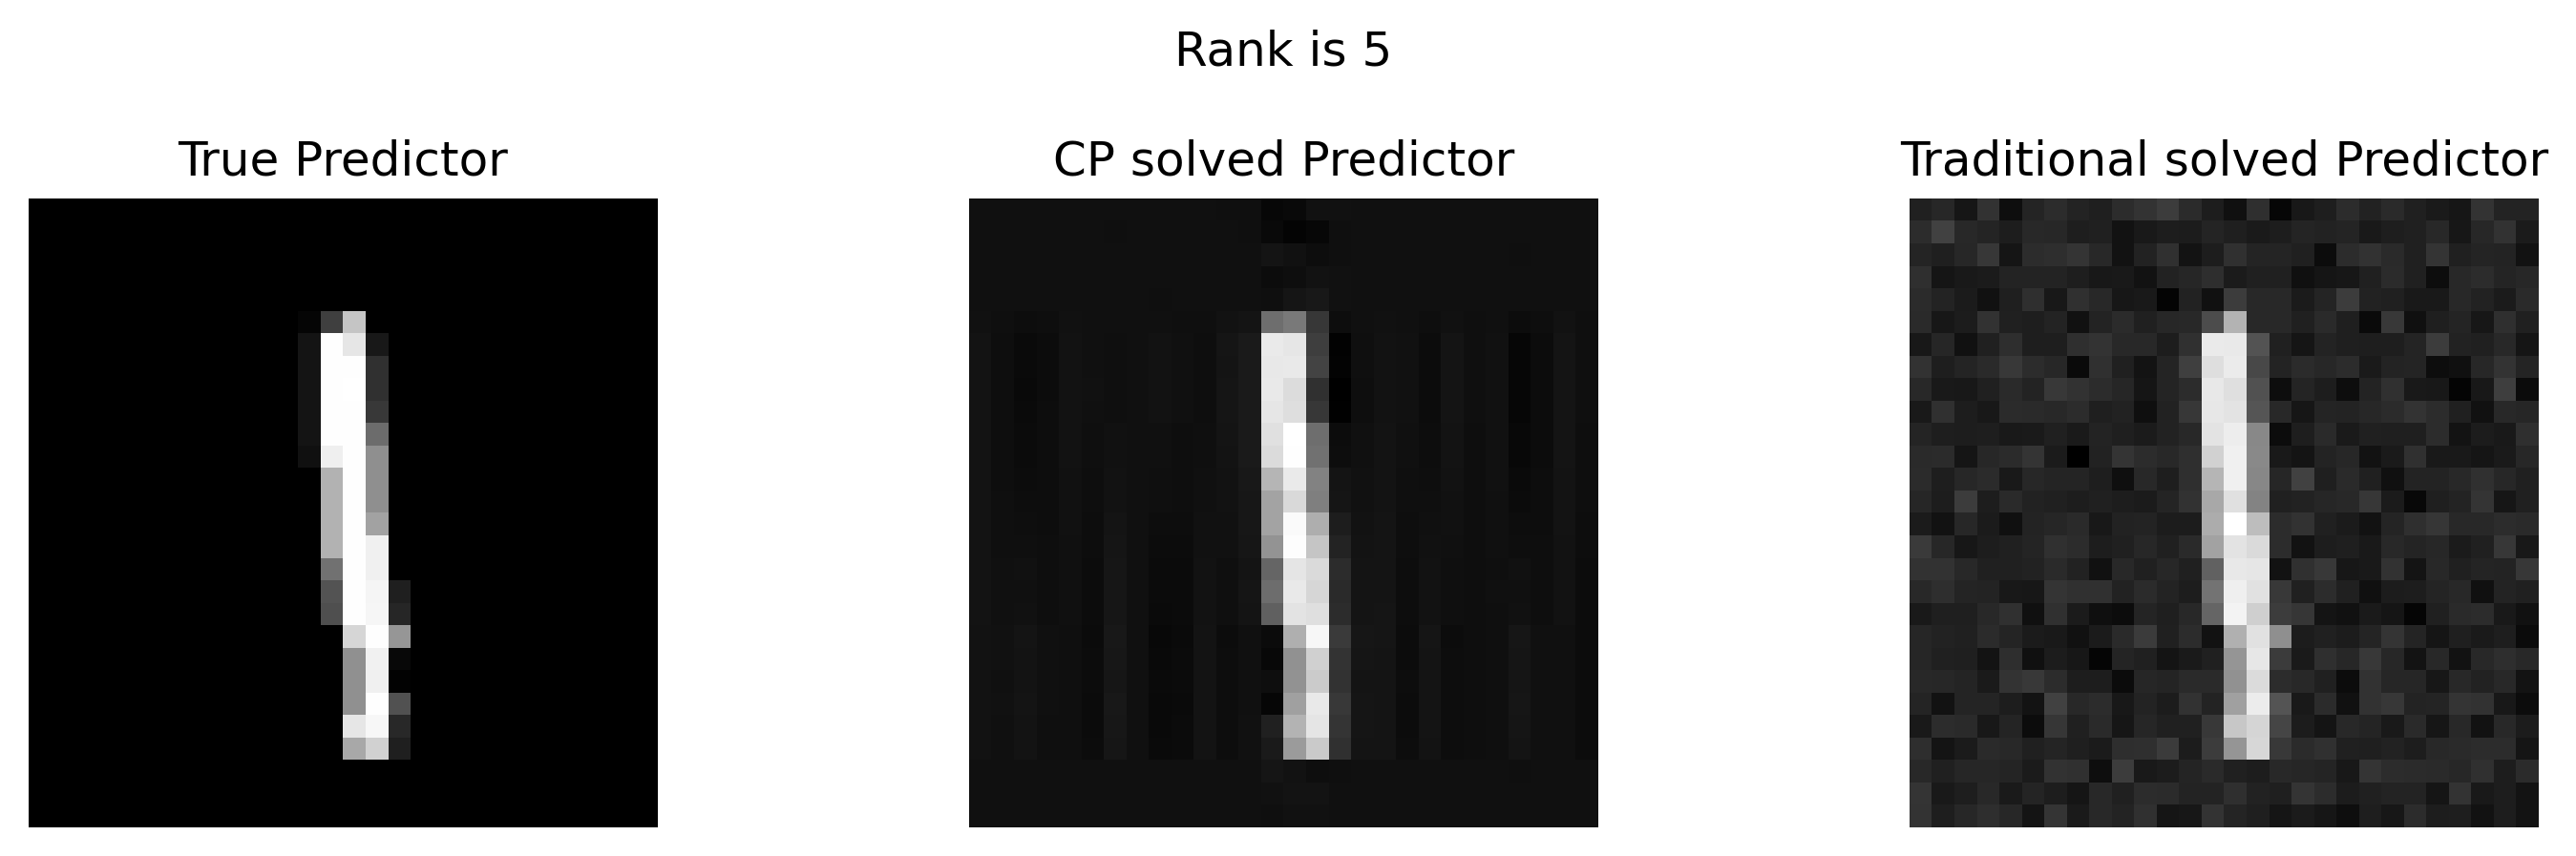

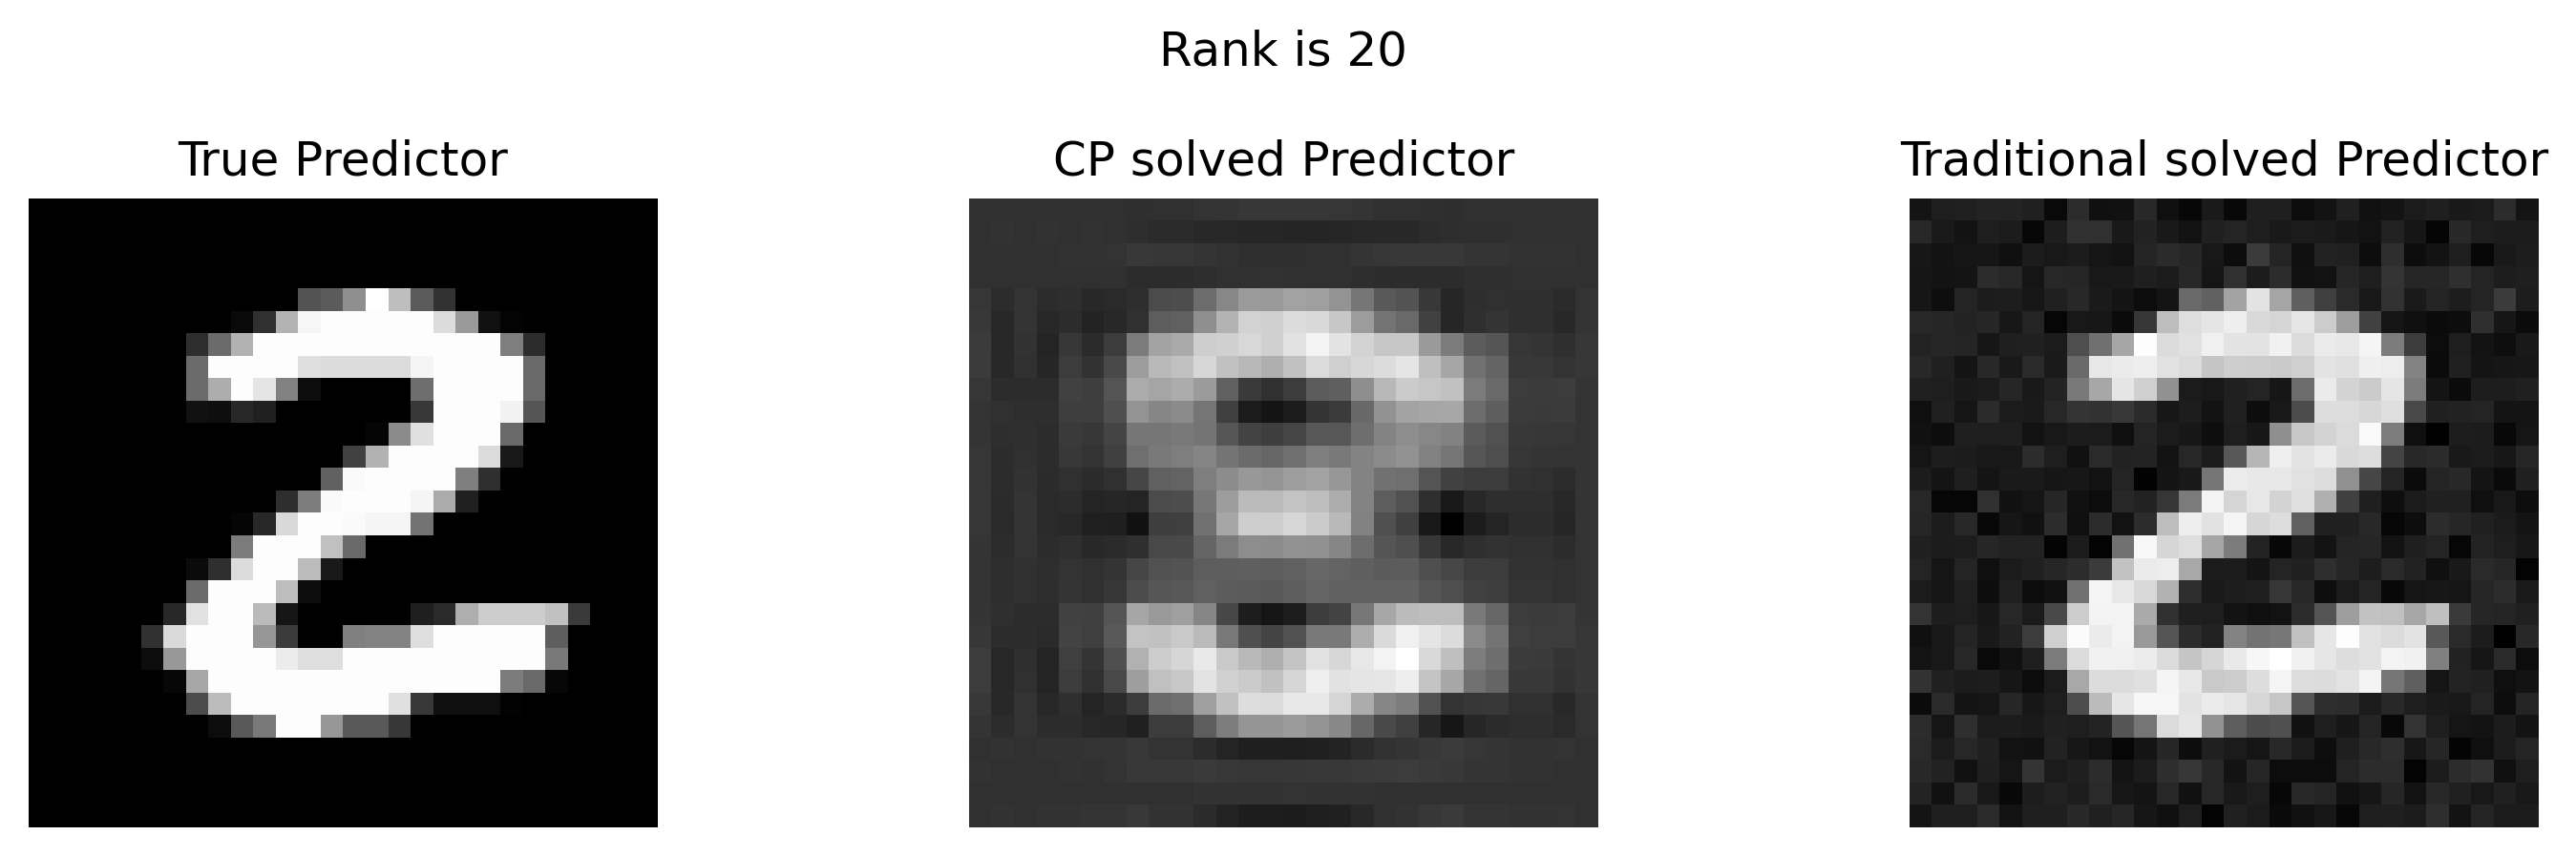

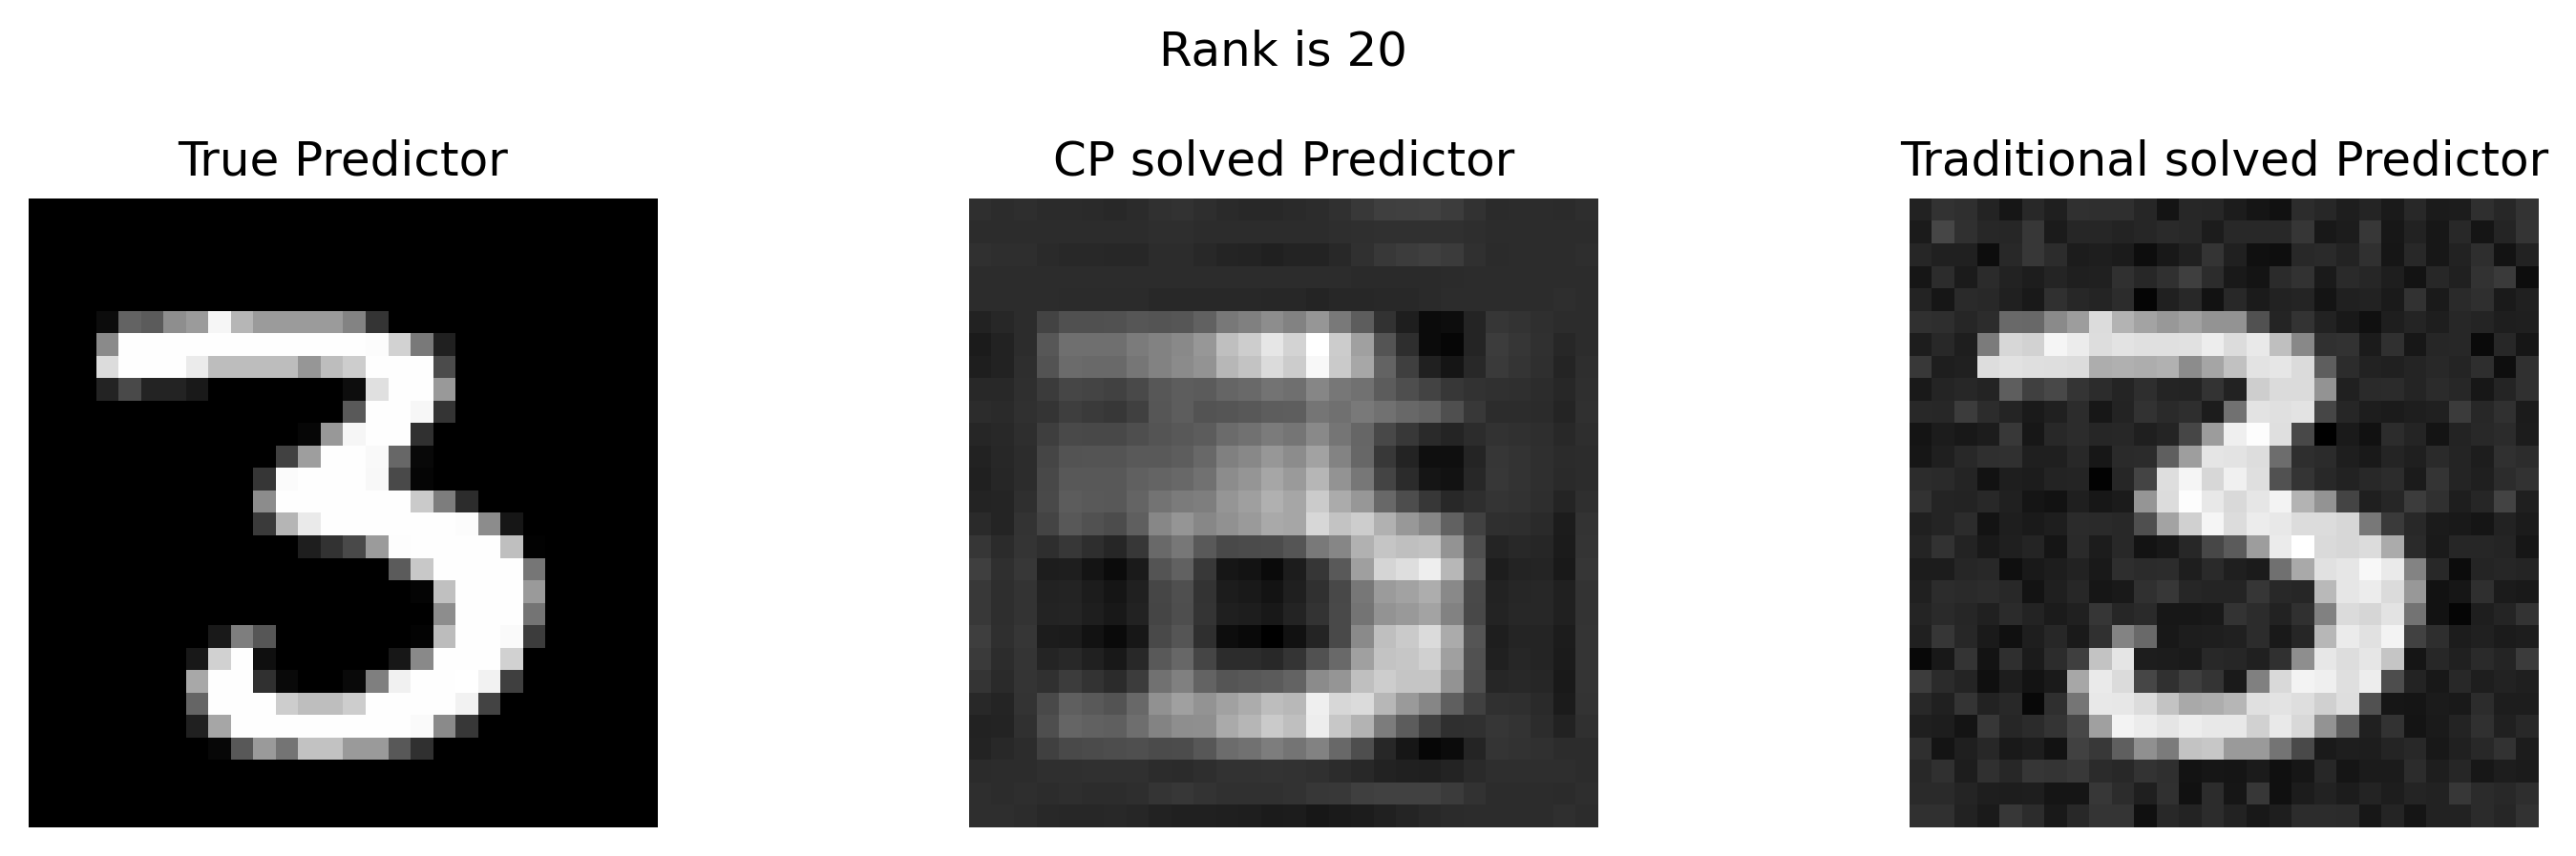

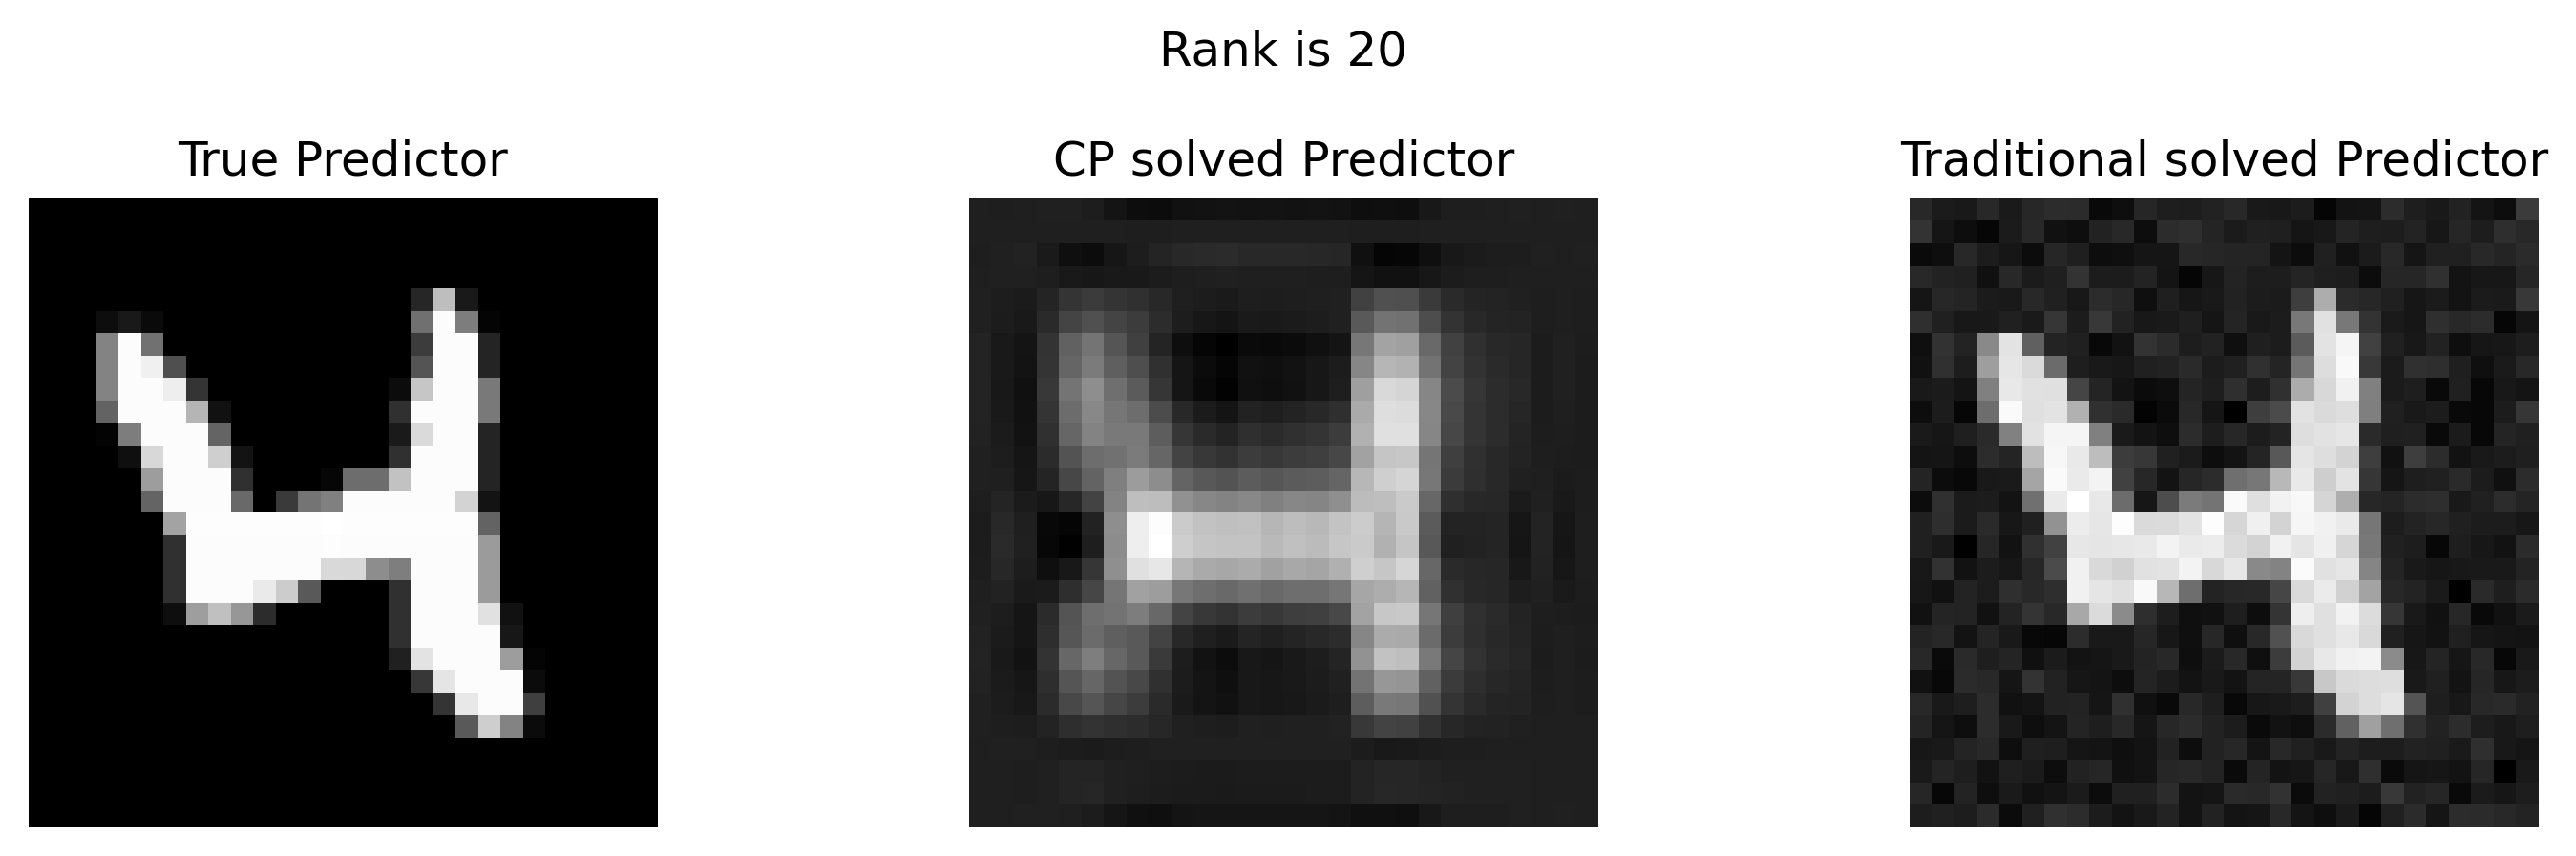

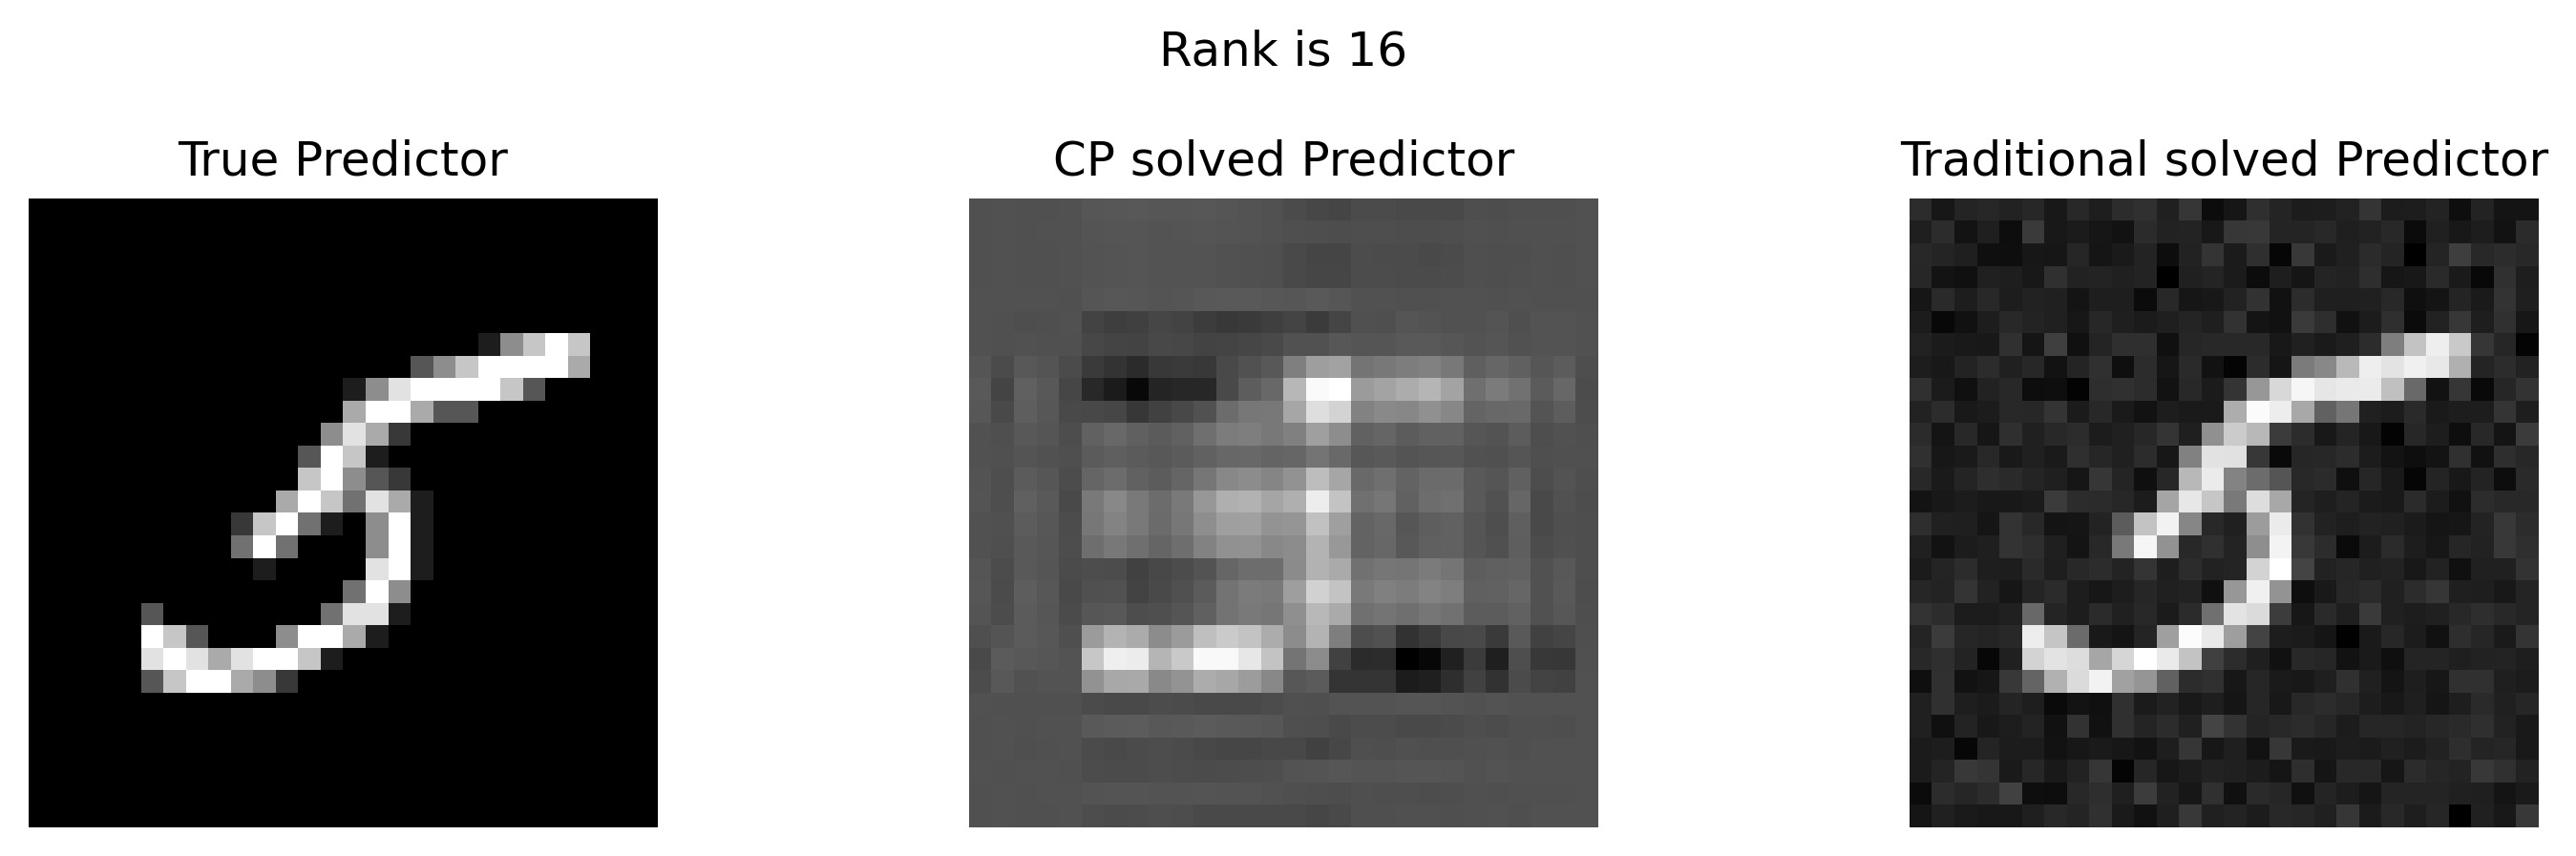

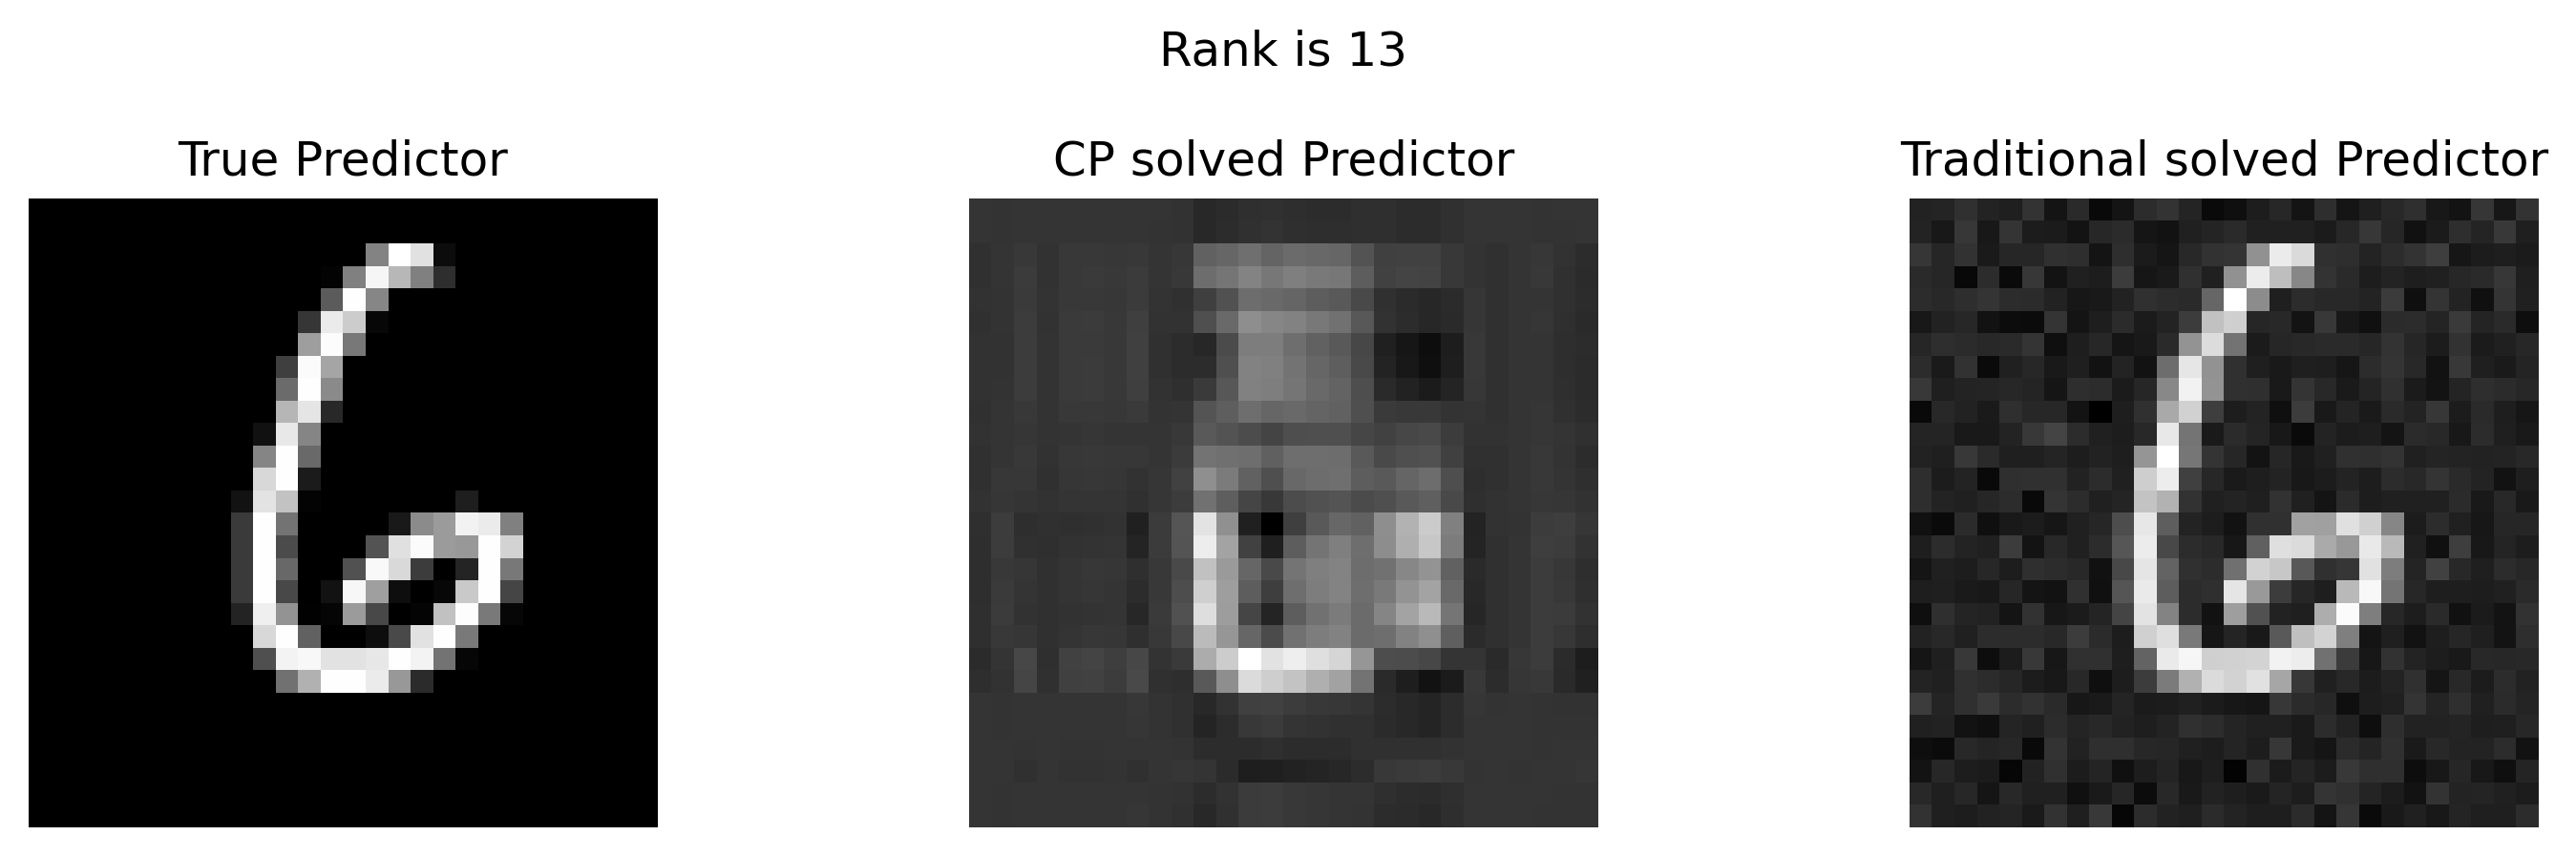

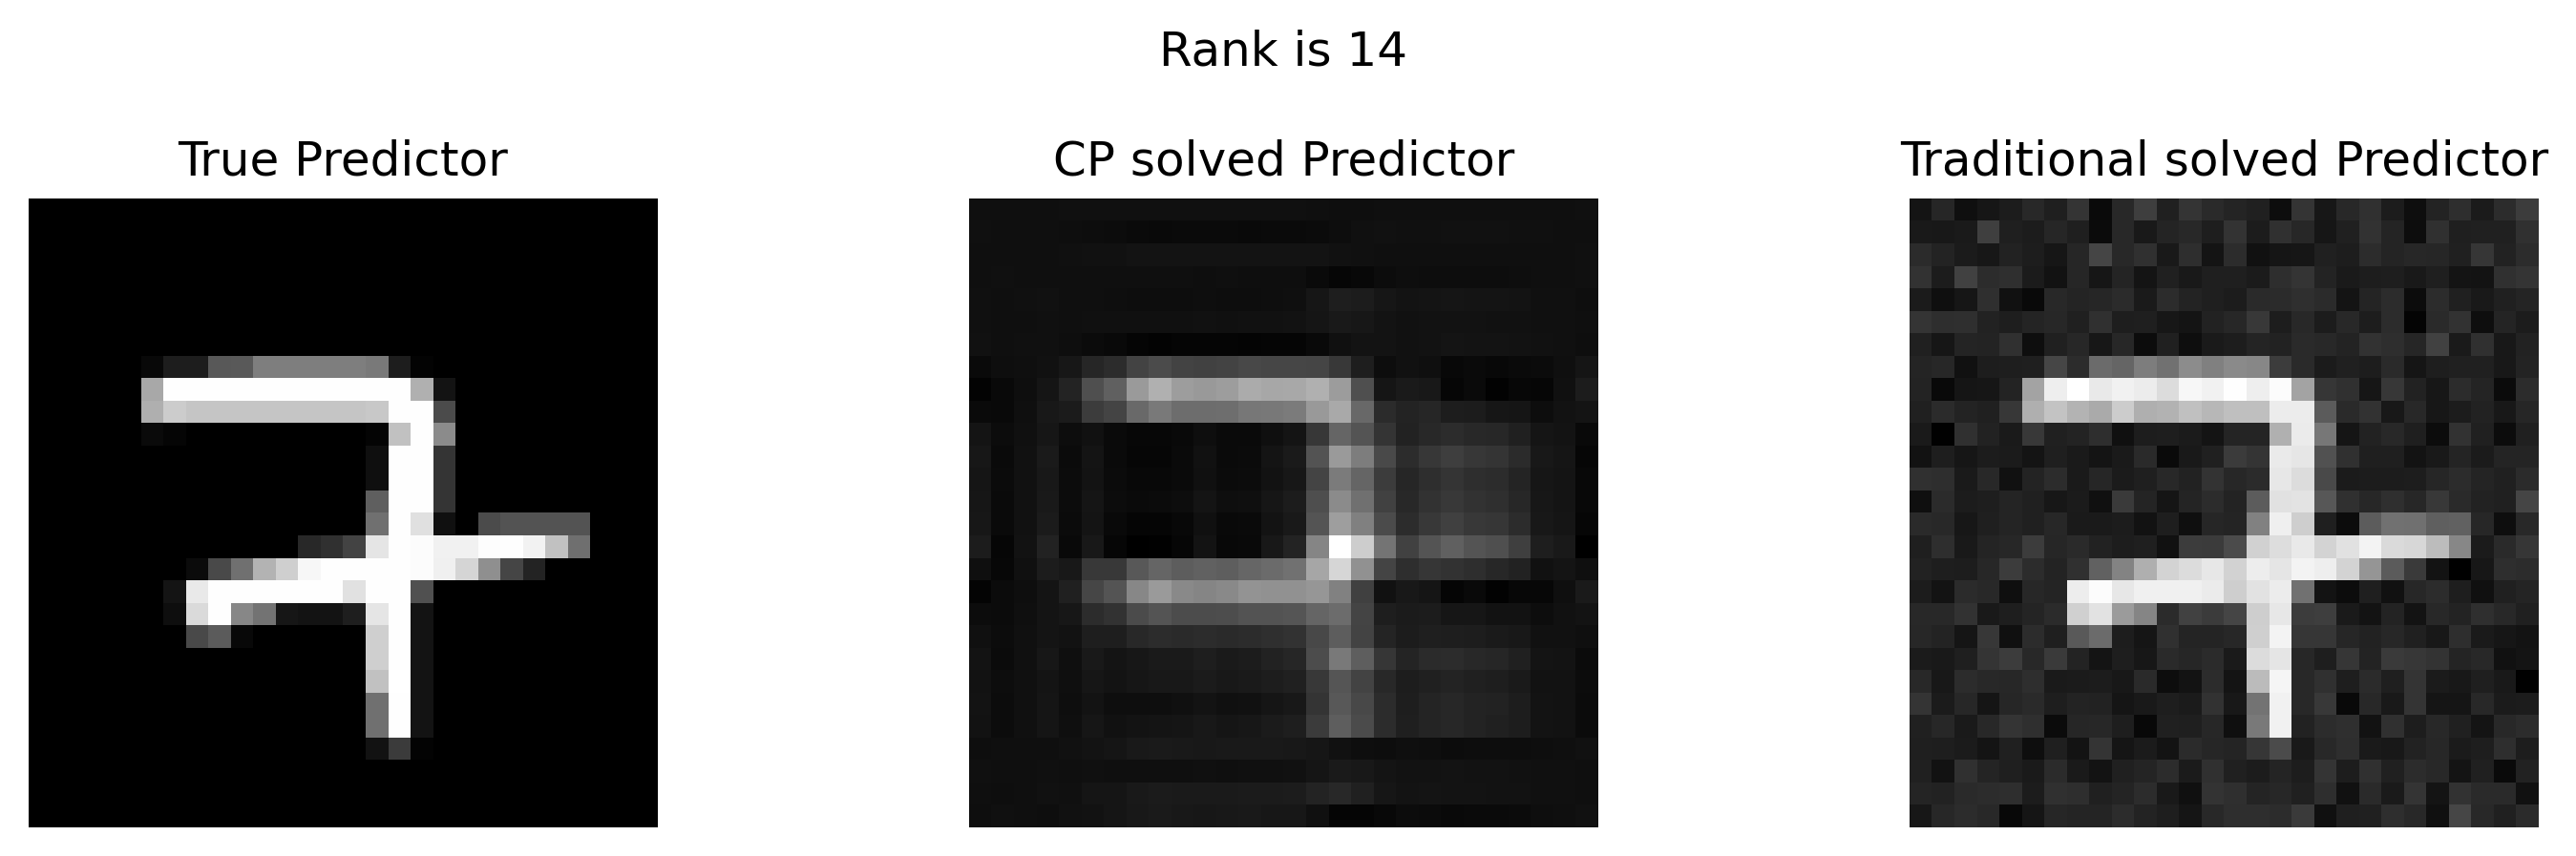

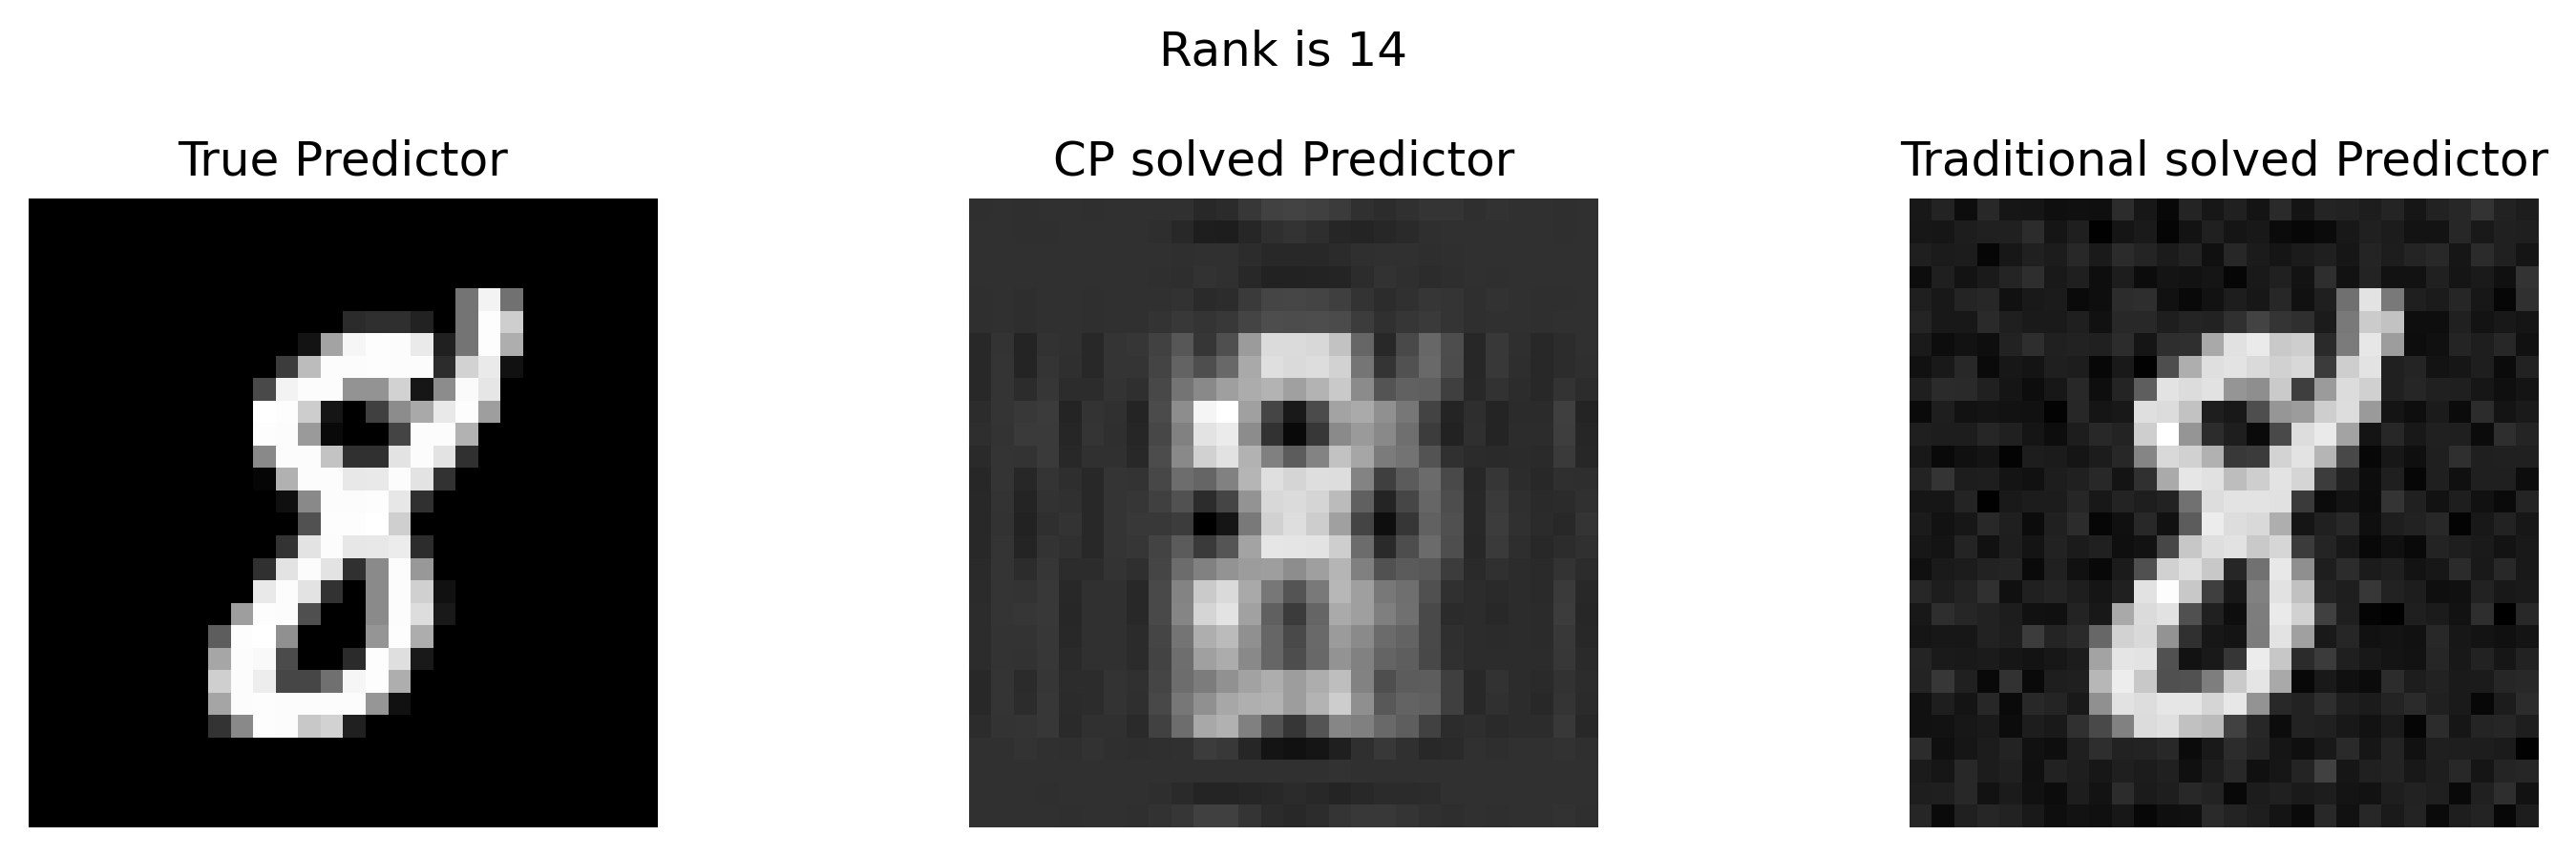

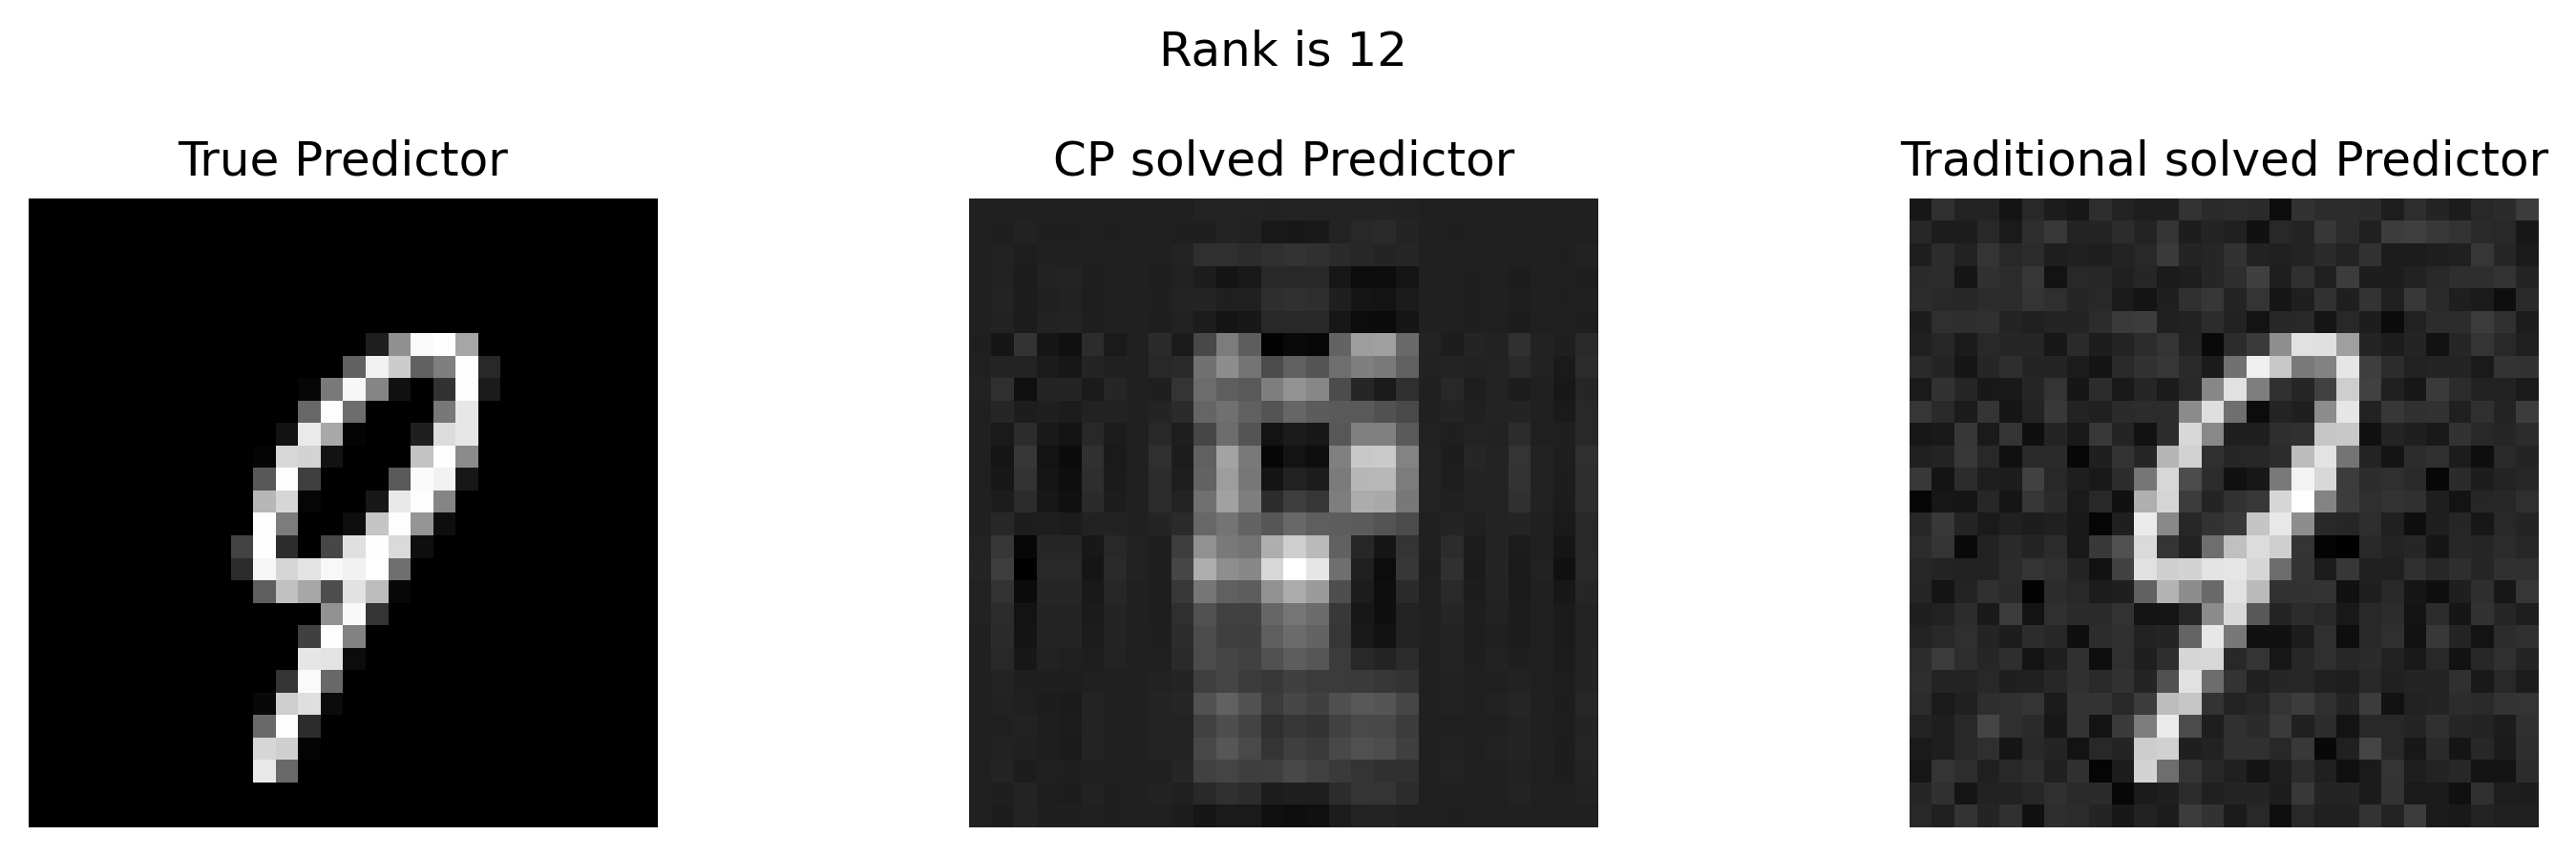

In [28]:
for i in range(10):
    #print(f)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi=300)

    ax[0].imshow(beta_arr[i], cmap='gray')
    ax[0].set_title('True Predictor')
    ax[0].set_axis_off()
    ax[1].imshow(dct_cp['predictor'][i], cmap='gray')
    ax[1].set_title('CP solved Predictor')
    ax[1].set_axis_off()
    ax[2].imshow(dct_vec['predictor'][i], cmap='gray')
    ax[2].set_title('Traditional solved Predictor')
    ax[2].set_axis_off()
    fig.suptitle(f"Rank is {np.linalg.matrix_rank(beta_arr[i])}")
    fig.tight_layout()
    fig.savefig('images/digits/'+str(i)+'.png')
    plt.show()